In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the required library

In [7]:
import os
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow
from keras import regularizers
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import skimage
import cv2
import skimage
import matplotlib.pyplot as plt
from skimage import color
from skimage.transform import resize, rotate
from skimage.util import crop
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import load
from numpy import expand_dims

In [9]:
# Input image size required
SIZE = 256

# Paths to dataset
# /content/drive/MyDrive/CUHK Dataset/CUHK_testing_cropped_photos
image_path = '/content/drive/MyDrive/CUHK Dataset/CUHK Dataset/CUHK_training_cropped_photos/'
img_array = []

sketch_path = '/content/drive/MyDrive/CUHK Dataset/CUHK Dataset/CUHK_training_cropped_sketches/'
sketch_array = []

test_image_path = '/content/drive/MyDrive/CUHK Dataset/CUHK Dataset/CUHK_testing_cropped_photos/'
test_img_array = []

test_sketch_path = '/content/drive/MyDrive/CUHK Dataset/CUHK Dataset/CUHK_testing_cropped_sketches/'
test_sketch_array = []

# Image and their corresponding file names in a sorted manner based on their names
image_file = sorted(os.listdir(image_path))
sketch_file = sorted(os.listdir(sketch_path))
test_image_file = sorted(os.listdir(test_image_path))
test_sketch_file = sorted(os.listdir(test_sketch_path))


In [10]:
# Pre-processing the image
def image_preprocessing(file_name, img_path, size):
  storage_array = []
  for img_file in tqdm(file_name):
    x = img_path + img_file
    c = (cv2.resize(cv2.imread(x).astype('float32'),(SIZE,SIZE)))/255.0
    #c = color.rgb2gray(c)
    storage_array.append(c)


  # Returning storage array where we have stored all our pre-processed images
  return np.array(storage_array)

In [11]:
# Calling pre-processing functions 
img_array = image_preprocessing(image_file, image_path, SIZE)
sketch_array = image_preprocessing(sketch_file, sketch_path, SIZE)
test_img_array = image_preprocessing(test_image_file, test_image_path, SIZE)
test_sketch_array = image_preprocessing(test_sketch_file, test_sketch_path, SIZE)


100%|██████████| 100/100 [00:01<00:00, 63.01it/s]


In [12]:
 # Print the number of colored and sketch images present
print("Total number of Training Colored images:",len(img_array))
print("Total number of Training sketch images:",len(sketch_array))

print("Total number of Testing Colored images:",len(test_img_array))
print("Total number of Testing sketch images:",len(test_sketch_array))

Total number of Training Colored images: 88
Total number of Training sketch images: 88
Total number of Testing Colored images: 100
Total number of Testing sketch images: 100


In [13]:
x_train = img_array
y_train = sketch_array
x_test = test_img_array
y_test = test_sketch_array

In [14]:
# Prinint the shape of train and test
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((88, 256, 256, 3), (88, 256, 256, 3), (100, 256, 256, 3), (100, 256, 256, 3))

In [15]:
dataset1 = [y_train, x_train]

# For 20 epochs

In [16]:
# Variable to store all the functions
temp_store = []

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models # epoch
def train(d_model, g_model, gan_model, dataset, n_epochs=20, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
	
		# Store all the losses
		temp_store.append((i+1, d_loss1, d_loss2, g_loss))

		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [17]:
# load image data
dataset = dataset1
print('Loaded', dataset[0].shape, dataset[1].shape)
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (88, 256, 256, 3) (88, 256, 256, 3)
Loaded (88, 256, 256, 3) (88, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, d1[0.257] d2[1.032] g[66.686]
>2, d1[0.400] d2[1.170] g[66.169]
>3, d1[0.437] d2[0.905] g[55.585]
>4, d1[0.263] d2[0.763] g[51.762]
>5, d1[0.251] d2[0.575] g[45.704]
>6, d1[0.235] d2[0.538] g[44.252]
>7, d1[0.358] d2[0.379] g[49.072]
>8, d1[0.301] d2[0.287] g[46.951]
>9, d1[0.197] d2[0.233] g[42.760]
>10, d1[0.333] d2[0.230] g[47.577]
>11, d1[0.285] d2[0.345] g[40.830]
>12, d1[0.155] d2[0.155] g[40.276]
>13, d1[0.144] d2[0.093] g[33.576]
>14, d1[0.135] d2[0.111] g[30.226]
>15, d1[0.193] d2[0.171] g[31.075]
>16, d1[0.202] d2[0.131] g[25.937]
>17, d1[0.100] d2[0.064] g[27.657]
>18, d1[0.084] d2[0.123] g[23.222]
>19, d1[0.063] d2[0.117] g[24.637]
>20, d1[0.072] d2[0.041] g[20.399]
>21, d1[0.055] d2[0.071] g[20.138]
>22, d1[0.082] d2[0.068] g[22.026]
>23, d1[0.054] d2[0.127] g[24.431]
>24, d1[1.348] d2[0.653] g[19.387]
>25, d1[0.212] d2[0.155] g[18.644]
>26, d1[0.102] d2[0.162] g[17.520]
>27, d1[0.118] d2[0.202] g[14.649]
>28, d1[0.217] d2[0.145] g[22.970]
>29, d1[0.463] d2[1.116] g[14

Loaded (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loaded (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loaded (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


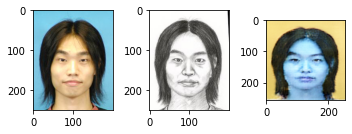

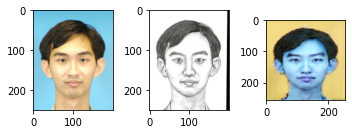

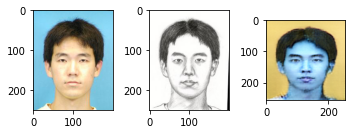

In [18]:
model_saved_name = 'model_001760.h5'
model_20 = model_saved_name

# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels

for i in range(50, 53):
	# Image to predict and display
	img_no = i

	# load source image
	#xxx = test_image_path + test_image_file[img_no]
	xxx = test_sketch_path + test_sketch_file[img_no]
	src_image = load_image(xxx)
	print('Loaded', src_image.shape)

	# load model
	model = load_model(model_saved_name)

	# generate image from source
	gen_image = model.predict(src_image)

	# Original
	vv1 = plt.imread(test_image_path + test_image_file[img_no])

	#Sketch
	vv2 = plt.imread(test_sketch_path + test_sketch_file[img_no])

	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
	axes[0].imshow(vv1)
	axes[1].imshow(vv2)
	axes[2].imshow(gen_image[0])
	fig.tight_layout()

In [19]:
loss_bank_epoch_20 = temp_store

# All the losses per steps
step_number  =  [i[0] for i in temp_store]
D_realsamples = [i[1] for i in temp_store]
D_generatedsamples = [i[2] for i in temp_store]
G_generated = [i[3] for i in temp_store]

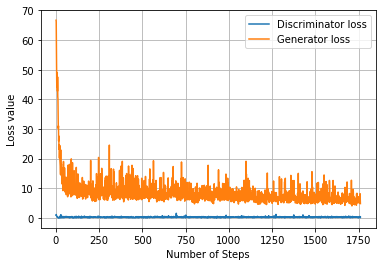

In [20]:
#plt.plot(step_number, D_realsamples)
plt.plot(step_number, D_generatedsamples)
plt.plot(step_number, G_generated)
plt.xlabel('Number of Steps')
plt.ylabel("Loss value")
plt.grid()
plt.legend(['Discriminator loss','Generator loss'])

# For 40 epochs

In [21]:
temp_store = []

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models # epoch
def train(d_model, g_model, gan_model, dataset, n_epochs=40, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
	
		# Store all the losses
		temp_store.append((i+1, d_loss1, d_loss2, g_loss))

		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [22]:
# load image data
dataset = dataset1
print('Loaded', dataset[0].shape, dataset[1].shape)
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (88, 256, 256, 3) (88, 256, 256, 3)
Loaded (88, 256, 256, 3) (88, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, d1[0.433] d2[0.733] g[64.629]
>2, d1[0.670] d2[0.712] g[64.457]
>3, d1[0.500] d2[0.609] g[63.173]
>4, d1[0.350] d2[0.470] g[54.116]
>5, d1[0.352] d2[0.547] g[45.706]
>6, d1[0.325] d2[0.447] g[43.564]
>7, d1[0.256] d2[0.328] g[48.464]
>8, d1[0.260] d2[0.293] g[40.820]
>9, d1[0.328] d2[0.285] g[32.916]
>10, d1[0.370] d2[0.246] g[34.656]
>11, d1[0.182] d2[0.190] g[42.475]
>12, d1[0.122] d2[0.114] g[26.440]
>13, d1[0.119] d2[0.091] g[39.459]
>14, d1[0.112] d2[0.088] g[27.552]
>15, d1[0.072] d2[0.069] g[26.695]
>16, d1[0.114] d2[0.099] g[28.158]
>17, d1[0.362] d2[0.198] g[29.958]
>18, d1[0.268] d2[0.327] g[24.047]
>19, d1[0.075] d2[0.152] g[21.145]
>20, d1[0.173] d2[0.155] g[26.686]
>21, d1[0.109] d2[0.073] g[20.941]
>22, d1[0.051] d2[0.059] g[19.197]
>23, d1[0.079] d2[0.074] g[20.324]
>24, d1[0.421] d2[1.462] g[23.391]
>25, d1[0.185] d2[0.148] g[19.690]
>26, d1[0.861] d2[0.645] g[14.939]
>27, d1[0.123] d2[0.461] g[16.252]
>28, d1[0.408] d2[0.317] g[13.688]
>29, d1[0.270] d2[0.223] g[18

Loaded (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loaded (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loaded (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


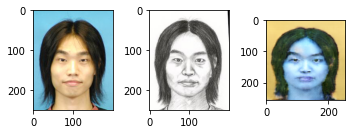

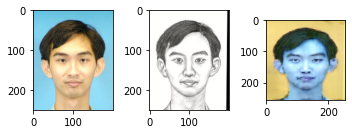

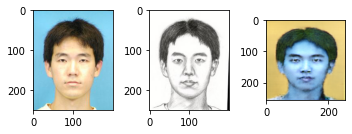

In [23]:
model_saved_name = 'model_003520.h5'
model_40 = model_saved_name

# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels

for i in range(50, 53):
	# Image to predict and display
	img_no = i

	# load source image
	xxx = test_sketch_path + test_sketch_file[img_no]
	#xxx = test_image_path + test_image_file[img_no]
	src_image = load_image(xxx)
	print('Loaded', src_image.shape)

	# load model
	model = load_model(model_saved_name)

	# generate image from source
	gen_image = model.predict(src_image)

	# Original
	vv1 = plt.imread(test_image_path + test_image_file[img_no])

	#Sketch
	vv2 = plt.imread(test_sketch_path + test_sketch_file[img_no])

	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
	axes[0].imshow(vv1)
	axes[1].imshow(vv2)
	axes[2].imshow(gen_image[0])
	fig.tight_layout()

In [24]:
loss_bank_epoch_40 = temp_store

# All the losses per steps
step_number  =  [i[0] for i in temp_store]
D_realsamples = [i[1] for i in temp_store]
D_generatedsamples = [i[2] for i in temp_store]
G_generated = [i[3] for i in temp_store]

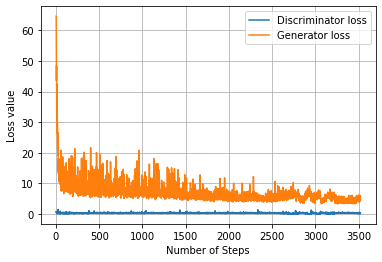

In [25]:
#plt.plot(step_number, D_realsamples)
plt.plot(step_number, D_generatedsamples)
plt.plot(step_number, G_generated)
plt.xlabel('Number of Steps')
plt.ylabel("Loss value")
plt.grid()
plt.legend(['Discriminator loss','Generator loss'])

# For 100 epochs

In [26]:
temp_store = []

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models # epoch
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
	
		# Store all the losses
		temp_store.append((i+1, d_loss1, d_loss2, g_loss))

		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [27]:
# load image data
dataset = dataset1
print('Loaded', dataset[0].shape, dataset[1].shape)
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (88, 256, 256, 3) (88, 256, 256, 3)
Loaded (88, 256, 256, 3) (88, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
>3813, d1[0.019] d2[0.203] g[6.251]
>3814, d1[0.058] d2[0.034] g[6.390]
>3815, d1[0.568] d2[0.479] g[4.467]
>3816, d1[0.054] d2[0.125] g[5.744]
>3817, d1[0.372] d2[0.526] g[4.423]
>3818, d1[0.176] d2[0.244] g[4.545]
>3819, d1[0.396] d2[0.266] g[5.066]
>3820, d1[0.052] d2[0.053] g[5.948]
>3821, d1[0.556] d2[0.320] g[4.302]
>3822, d1[0.124] d2[0.183] g[5.774]
>3823, d1[0.348] d2[0.126] g[4.700]
>3824, d1[0.077] d2[0.157] g[4.951]
>3825, d1[0.077] d2[0.239] g[5.292]
>3826, d1[0.155] d2[0.328] g[5.180]
>3827, d1[0.340] d2[0.507] g[4.810]
>3828, d1[0.600] d2[0.184] g[4.770]
>3829, d1[0.039] d2[0.179] g[4.914]
>3830, d1[0.314] d2[0.104] g[4.405]
>3831, d1[0.094] d2[0.247] g[7.359]
>3832, d1[0.070] d2[0.090] g[6.032]
>3833, d1[0.158] d2[0.302] g[5.264]
>3834, d1[0.117] d2[0.222] g[4.564]
>3835, d1[0.348] d2[0.638] g[5.539]
>3836, d1[0.183] d2[0.106] g[5.552]
>3837, d1[0.199] d2[0.148] g[4.986]
>3838, d1[0.480] d2[0.658] g[4.429]
>3839, d1[0.2

Loaded (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loaded (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loaded (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


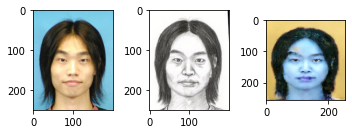

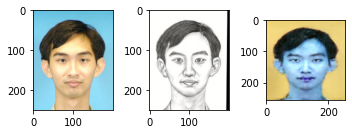

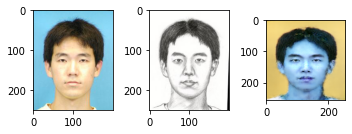

In [28]:
model_saved_name = 'model_008800.h5'
model_100 = model_saved_name

# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels

for i in range(50, 53):
	# Image to predict and display
	img_no = i

	# load source image
	xxx = test_sketch_path + test_sketch_file[img_no]
	#xxx = test_image_path + test_image_file[img_no]
	src_image = load_image(xxx)
	print('Loaded', src_image.shape)

	# load model
	model = load_model(model_saved_name)

	# generate image from source
	gen_image = model.predict(src_image)

	# Original
	vv1 = plt.imread(test_image_path + test_image_file[img_no])

	#Sketch
	vv2 = plt.imread(test_sketch_path + test_sketch_file[img_no])

	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
	axes[0].imshow(vv1)
	axes[1].imshow(vv2)
	axes[2].imshow(gen_image[0])
	fig.tight_layout()

In [29]:
loss_bank_epoch_100 = temp_store

# All the losses per steps
step_number  =  [i[0] for i in temp_store]
D_realsamples = [i[1] for i in temp_store]
D_generatedsamples = [i[2] for i in temp_store]
G_generated = [i[3] for i in temp_store]

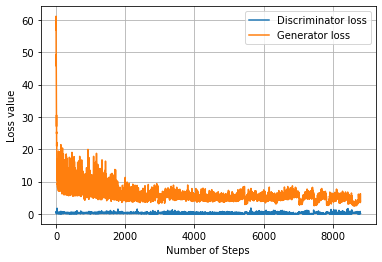

In [30]:
#plt.plot(step_number, D_realsamples)
plt.plot(step_number, D_generatedsamples)
plt.plot(step_number, G_generated)
plt.xlabel('Number of Steps')
plt.ylabel("Loss value")
plt.grid()
plt.legend(['Discriminator loss','Generator loss'])